In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
sess = tf.InteractiveSession()

**NOTE**: Either use the brown corpus (next 3 cells) or the babi corpus (below).

In [28]:
# Read a part of the brown corpus.
import nltk
words = nltk.corpus.brown.words(categories='news')
words = [word.lower() for word in words]

([<matplotlib.axis.XTick at 0x7f913e7a5c10>,
 <a list of 10 Text xticklabel objects>)

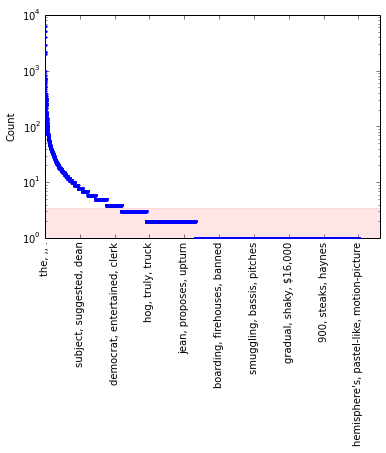

In [29]:
# Count word occurences and plot distribution

min_count = 4

from collections import Counter
counter = Counter(words)
most_common_words = [word for word, count in counter.most_common()]
most_common_counts = [count for word, count in counter.most_common()]
plt.axhspan(0, min_count - 0.5, color='r', alpha=0.1)
plt.plot(most_common_counts, '.', zorder=100)
plt.yscale('log', nonposy='clip')
plt.ylabel('Count')
#plt.xscale('log', nonposy='clip')
#ticks = np.logspace(0, 4, 10)
ticks = np.linspace(0, len(most_common_words)-3, 10)
labels = [', '.join(most_common_words[int(i):int(i)+3]) for i in ticks]
plt.xticks(ticks, labels, rotation='vertical')

In [30]:
# Replace infrequent words by <UNK>.
infrequent_words = [word for word, count in counter.items() if count < min_count]
print 'Replacing {} infrequent words with <UNK>: {}...'.format(len(infrequent_words), ', '.join(infrequent_words[:5]))
for i, word in enumerate(words):
    if word in infrequent_words:
        words[i] = '<UNK>'
words

Replacing 9925 infrequent words with <UNK>: sunbonnet, yellow, narcotic, boogie, railing...


[u'the',
 u'fulton',
 u'county',
 u'grand',
 u'jury',
 u'said',
 u'friday',
 u'an',
 u'investigation',
 u'of',
 u"atlanta's",
 u'recent',
 u'primary',
 u'election',
 u'produced',
 u'``',
 u'no',
 u'evidence',
 u"''",
 u'that',
 u'any',
 '<UNK>',
 u'took',
 u'place',
 u'.',
 u'the',
 u'jury',
 u'further',
 u'said',
 u'in',
 '<UNK>',
 '<UNK>',
 u'that',
 u'the',
 u'city',
 u'executive',
 u'committee',
 u',',
 u'which',
 u'had',
 '<UNK>',
 u'charge',
 u'of',
 u'the',
 u'election',
 u',',
 u'``',
 '<UNK>',
 u'the',
 '<UNK>',
 u'and',
 u'thanks',
 u'of',
 u'the',
 u'city',
 u'of',
 u'atlanta',
 u"''",
 u'for',
 u'the',
 u'manner',
 u'in',
 u'which',
 u'the',
 u'election',
 u'was',
 u'conducted',
 u'.',
 u'the',
 '<UNK>',
 u'term',
 u'jury',
 u'had',
 u'been',
 u'charged',
 u'by',
 u'fulton',
 u'superior',
 u'court',
 u'judge',
 '<UNK>',
 '<UNK>',
 u'to',
 '<UNK>',
 u'reports',
 u'of',
 u'possible',
 u'``',
 '<UNK>',
 u"''",
 u'in',
 u'the',
 '<UNK>',
 u'primary',
 u'which',
 u'was',
 u'won'

In [3]:
# Read babi stories.
# Download the dataset from https://research.facebook.com/research/babi/ and unpack it.
words = []
with open('babi/en/qa1_single-supporting-fact_train.txt') as f:
    for line in f:
        if not '?' in line:  # omit questions
            words.extend(line[:-2].split()[1:])  # remove line number and period
            words.append('.')

In [4]:
vocab = set(words)
len(words), len(vocab)

(12390, 18)

In [5]:
def to_onehot(labels, num_classes):
    arr = np.zeros((len(labels), num_classes))
    for label, vector in zip(labels, arr):
        vector[label] = 1.
    return arr

def words_to_indices(words, vocab):
    word_to_index = dict(zip(vocab, range(len(vocab))))
    return np.array([word_to_index[word] for word in words])

def indices_to_words(indices, vocab):
    index_to_word = dict(zip(range(len(vocab)), vocab))
    return [index_to_word[index] for index in indices]

In [6]:
X_train = words_to_indices(words[:-1] + words[1:], vocab)
X_train.shape, X_train

((24778,), array([16,  5,  9, ..., 14, 17,  8]))

In [7]:
y_train = words_to_indices(words[1:] + words[:-1], vocab).reshape(-1, 1)
y_train.shape, y_train

((24778, 1), array([[ 5],
        [ 9],
        [14],
        ..., 
        [ 9],
        [14],
        [17]]))

In [8]:
# Model. 
batch_size = 128
X = tf.placeholder(tf.int32, [None])
y_true = tf.placeholder(tf.int32, [None, 1])

In [9]:
d = 128
V = tf.Variable(tf.random_uniform([len(vocab), d], -1., 1.))  # embeddings for center word; each row is one word vector
U = tf.Variable(tf.random_uniform([len(vocab), d], -1., 1.))  # embeddings for outside word

In [10]:
H = tf.nn.embedding_lookup(V, X)  # "hidden" layer

In [11]:
logits = tf.matmul(H, tf.transpose(U))  # TODO: Experiment with a_is_sparse=True in first matmul
y = tf.nn.softmax(logits)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(y, 1), tf.int32), y_true), tf.float32))

In [12]:
# True softmax loss.
full_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf.reshape(y_true, [-1])))

In [13]:
# Sampled softmax loss.
biases = tf.zeros([len(vocab)])  # use zero bias, because it's required in sampled_softmax_loss
num_sample = 8  # 8 for babi, 64 for brown
num_classes = len(vocab)
sampled_loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(U, biases, H, y_true, num_sample, num_classes))

In [14]:
train_step = tf.train.GradientDescentOptimizer(1.).minimize(sampled_loss)

In [15]:
tf.initialize_all_variables().run()

In [16]:
def to_batches(*arrays, **kwargs):
    """Yield shuffled mini batches from several arrays for one epoch"""
    batch_size = kwargs.pop('batch_size', 128)
    
    for array in arrays[1:]:  # check that all arrays have the same length
        if len(array) != len(arrays[0]):
            raise ValueError('All arrays must have same length')
            
    num_batches = len(arrays[0]) / batch_size
    batch_indices = np.random.choice(len(X_train), (num_batches, batch_size), replace=False)  # pick array indices for each batch
    
    for ind in batch_indices:
        if len(arrays) == 1:
            yield arrays[0][ind]
        else:
            yield [array[ind] for array in arrays]

In [17]:
# Initialize tensorboard.
writer = tf.train.SummaryWriter('/tmp/tflogs', graph=tf.get_default_graph())
tf.scalar_summary('full softmax loss', full_loss)
tf.scalar_summary('sampled softmax loss', sampled_loss)
tf.scalar_summary('accuracy', acc)
summary_op = tf.merge_all_summaries()  # invoke only once

In [18]:
# Training.
from scipy.spatial.distance import cosine

def get_closest(embeddings, index, n):
    """Return indices of the `n` closest embeddings to the embedding at `index` (measured by the cosine distance)."""
    word_vector = embeddings[index]
    distances = [cosine(word_vector, other_word_vector) for other_word_vector in embeddings]
    sorted_distances = sorted(enumerate(distances), key=lambda (i, dist): dist)
    closest_indices = [i for i, dist in sorted_distances[1:n+1]]  # omit word_vector itself
    return closest_indices    

eval_indices = np.random.choice(len(vocab), min(len(vocab), 1000), replace=False)  # pick elements for evaluation here, so they are consistent across epochs

for epoch in range(1, 151):
    for X_batch, y_batch in to_batches(X_train, y_train, batch_size=batch_size):
        train_step.run(feed_dict={X: X_batch, y_true: y_batch})
        
    # Evaluate on a random subset of the training data.
    summary, full_loss_train, sampled_loss_train, acc_train = sess.run([summary_op, full_loss, sampled_loss, acc], 
                                                               feed_dict={X: X_train[eval_indices], y_true: y_train[eval_indices]})
    print 'Epoch {:3d} - full loss {:6.3f} - sampled loss {:6.3f} - acc {:6.3f}'.format(epoch, full_loss_train, sampled_loss_train, acc_train)
    writer.add_summary(summary, epoch)
        
    if epoch % 10 == 0:
        # Show closest neighbors for some words from the vocabulary.
        embeddings = V.eval()
        for ind in np.random.choice(len(vocab), 5, replace=False):
            closest_words = indices_to_words(get_closest(embeddings, ind, 5), vocab)
            print 'Closest to {}: {}'.format(indices_to_words([ind], vocab)[0], ', '.join(closest_words))

Epoch   1 - full loss  1.893 - sampled loss  1.066 - acc  0.117
Epoch   2 - full loss  1.533 - sampled loss  0.982 - acc  0.136
Epoch   3 - full loss  1.895 - sampled loss  1.602 - acc  0.096
Epoch   4 - full loss  1.853 - sampled loss  1.333 - acc  0.139
Epoch   5 - full loss  1.429 - sampled loss  0.905 - acc  0.136
Epoch   6 - full loss  1.585 - sampled loss  1.179 - acc  0.127
Epoch   7 - full loss  1.762 - sampled loss  1.102 - acc  0.157
Epoch   8 - full loss  1.415 - sampled loss  0.947 - acc  0.142
Epoch   9 - full loss  1.770 - sampled loss  1.059 - acc  0.160
Epoch  10 - full loss  1.447 - sampled loss  0.986 - acc  0.139
Closest to Daniel: back, kitchen, John, journeyed, hallway
Closest to hallway: journeyed, kitchen, travelled, moved, to
Closest to John: bathroom, bedroom, Daniel, moved, to
Closest to Sandra: kitchen, travelled, back, journeyed, moved
Closest to kitchen: Sandra, went, hallway, Daniel, travelled
Epoch  11 - full loss  1.582 - sampled loss  0.965 - acc  0.117

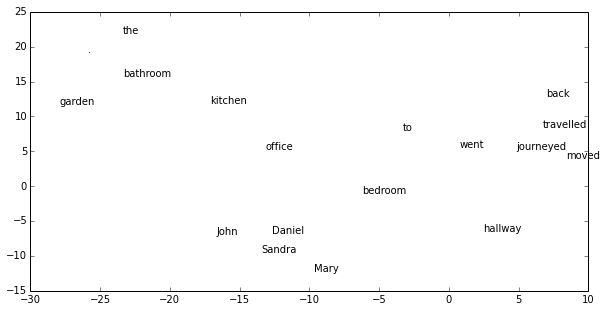

In [20]:
from sklearn.manifold import TSNE

def plot_embeddings(embeddings, words):
    model = TSNE(n_components=2, perplexity=2, learning_rate=10, random_state=0)
    vectors = model.fit_transform(embeddings)
    for (x, y), word in zip(vectors, words):
        plt.plot(x, y)  # add empty line to make xlim and ylim work automatically
        plt.text(x, y, word, horizontalalignment='center', verticalalignment='center')

plt.figure(figsize=(10, 5))
#embeddings = np.concatenate([V.eval(), U.eval()])
#embeddings = V.eval() + U.eval()
embeddings = V.eval()
plot_embeddings(embeddings, vocab)
# lim = 0.001
# plt.xlim(-lim, lim)
# plt.ylim(-lim, lim)
# plt.savefig('tsne.png', dpi=300)